In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp

In [2]:
A = -0.1
B = 0.5
C = 1
Q_mean = 1
Q_var = 4
lam = 1
sensor_var = 0.04
T_set = 2

seed_val = 1234

The below code runs the model as it were perfect and had 0 noise.

In [3]:
def feed_forward(t, y, A, B, C):

    lam = int(y <= T_set)
    return A * y + lam * (B * Q_mean)

In [4]:
sol1 = solve_ivp(feed_forward, [0, 100], [0], args = (A, B, C))

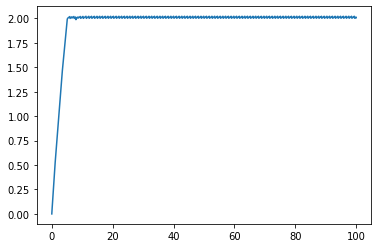

In [5]:
plt.plot(sol1.t,np.squeeze(sol1.y.T))

Now, let us introduce some noise in the model and measurements. Instead of using the conventional `solve_ivp` function, we make use of the Forward Euler time stepping scheme.

In [6]:
t = np.linspace(0,100,num=1000)
dt = t[1] - t[0]
theta = np.zeros(t.size) # observed (includes all noises)
theta_hat = np.zeros(t.size) # predicted by model (without any noise)
theta_real = np.zeros(t.size) # real temperature with the heater noise
np.random.seed(seed_val)
for i in range(t.size-1):

    lam = int(theta[i] <= T_set)
    e1 = np.random.normal()
    e2 = np.random.normal()

    theta_hat[i+1] = (1 + A * dt) * theta_hat[i] + lam * (B * Q_mean) * dt
    theta_real[i+1] = (1 + A * dt) * theta_real[i] + lam * (B * Q_mean + e1 * np.sqrt(Q_var)) * dt 
    theta[i+1] = theta_real[i+1] + e2 * np.sqrt(sensor_var)

Norm Error between Real and Predicted: 27.446160495690084
Norm Error between Real and Set Point: 9.82353330715767
Average Temperature: 2.1104665345247775


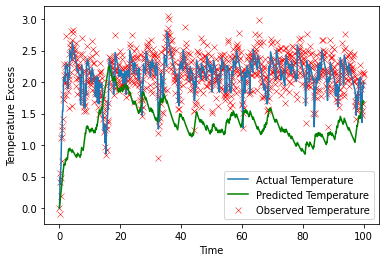

In [7]:
plt.plot(t,theta_real)
plt.plot(t,theta_hat,c = 'g')
plt.scatter(t,theta, marker = 'x', linewidth = 0.5, c = 'r')
plt.legend(['Actual Temperature', 'Predicted Temperature', 'Observed Temperature'])
plt.xlabel('Time')
plt.ylabel('Temperature Excess')
print('Norm Error between Real and Predicted:',np.linalg.norm(theta_real-theta_hat))
print('Norm Error between Real and Set Point:',np.linalg.norm(theta_real-T_set))
print('Average Temperature:', np.mean(theta_real))
plt.savefig('No-Filter Model (High Heater Noise)')

It is pretty evident that the basing the decision to turn on or turn off the heater based on the reading from the sensor is probably a bad decision. This is where a predictive and updating algorithm would be highly useful. Let us consider the Kalman Filter.

Steps within a Kalman Filter Algorithm are as follows:

1. Calculate Kalman Gain $K_k = P_k'C^T(CP_k'C^T + R)^{-1}$ where $P_k'$ is the prior estimate of the error, $R$ is the covariance matrix of the observation noise.
2. Update the prediction using $\hat{\theta} = \hat{\theta}' + K_k(z_k - C\hat{\theta}')$, where $z_k$ is the observed measurement.
3. Update the estimate of the error $P_k = (I - K_k C) P_k'$
4. Move to the next time step through a projection step:
$\hat{\theta}_{k+1}' = A \hat{\theta}_k $,  
$P_{k+1}' = A P_k A^T + Q$,
where $Q$ is the covariance matrix of the model noise.

In [1]:
t = np.linspace(0,100,num=1000)
dt = t[1] - t[0]
theta = np.zeros(t.size) # observed
theta_hat_prime = np.zeros(t.size) # predicted state (prior estimate)
theta_hat = np.zeros(t.size) # posterior estimate of theta_hat_prime
theta_real = np.zeros(t.size) # real theta including heater noise
P = np.zeros(t.size) # Posterior estimate of error covariance
P_prime = np.zeros(t.size) # Prior estimate of error covariance
K = np.zeros(t.size) # Kalman Gain
lam = np.zeros(t.size)
P_prime[0] = 1

NameError: name 'np' is not defined

In [2]:
np.random.seed(seed_val)
for i in range(t.size-1):

    lam[i] = int(theta[i] <= T_set)
    e1 = np.random.normal()
    e2 = np.random.normal()

    K[i] = P_prime[i] * C / (C * P_prime[i] * C + sensor_var)
    theta_hat[i] = theta_hat_prime[i] + K[i] * (theta[i] - C * theta_hat_prime[i])
    P[i] = (1 - K[i] * C) * P_prime[i]
    theta_hat_prime[i+1] = (1 + A * dt) * theta_hat[i] + lam[i] * (B * Q_mean) * dt # X_dot = AX + BU
    theta_real[i+1] = (1 + A * dt) * theta_real[i] + lam[i] * (B * Q_mean + e1 * np.sqrt(Q_var)) * dt # X_dot = AX + BU + Noise
    theta[i+1] = C * theta_real[i+1] + e2 * np.sqrt(sensor_var) # Y = CX + Noise
    P_prime[i+1] = (1 + A * dt) * P[i] * (1 + A * dt) + Q_var

i = t.size-1
K[i] = P_prime[i] * C / (C * P_prime[i] * C + sensor_var)
theta_hat[i] = theta_hat_prime[i] + K[i] * (theta[i] - C * theta_hat_prime[i])
P[i] = (1 - K[i] * C) * P_prime[i]

NameError: name 'np' is not defined

Norm Error between Real and Predicted: 6.247968196079028
Norm Error between Real and Set Point: 9.82353330715767
Average Temperature: 2.1104665345247775


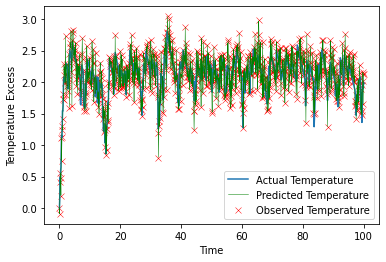

In [10]:
plt.plot(t,theta_real) # Actual temperature
plt.plot(t,theta_hat, c = 'g', linewidth = 0.5) # Predicted temperatures
plt.scatter(t,theta,marker = 'x', linewidth = 0.5, c = 'r') # Observed temperature
plt.legend(['Actual Temperature', 'Predicted Temperature', 'Observed Temperature'])
plt.xlabel('Time')
plt.ylabel('Temperature Excess')
print('Norm Error between Real and Predicted:',np.linalg.norm(theta_real-theta_hat))
print('Norm Error between Real and Set Point:',np.linalg.norm(theta_real-T_set))
print('Average Temperature:', np.mean(theta_real))
plt.savefig('Kalman Model (High Heater Noise)')

In the no-filter model, the predicted temperature has no consideration for the noise that is present in the system. The key advantage of the Kalman Filter is that it is able to improve the accuracy of the predictions based on the data observed by the sensor. This can be clearly seen by the decrease in the norm of the difference between the real and the predicted temperatures.

While it is unclear from the graph on which method is actually more accurate, the norm error between the real temperature and the set temperature reveals that the Kalman Filter method is better at maintaining a set temperature. Further, from the average temperatures over the entire time series, it can be seen that the Kalman Filter method performs better than the no-filter method.